In [26]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets 
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import LinearRegression
import warnings
warnings.filterwarnings('ignore')

#### 1. Загрузите данные с помощью библиотеки sklearn.

In [2]:
boston = datasets.load_boston()
X = boston.data
y = boston.target

#### 2. Разделите выборку на обучающую (75%) и контрольную (25%).

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

#### 3. Заведите массив для объектов DecisionTreeRegressor (они будут использоваться в качестве базовых алгоритмов) и для вещественных чисел (коэффициенты перед базовыми алгоритмами).

In [4]:
tree = DecisionTreeRegressor()

#### 4. В цикле обучите последовательно 50 решающих деревьев с параметрами max_depth=5 и random_state=42 (остальные параметры - по умолчанию). Каждое дерево должно обучаться на одном и том же множестве объектов, но ответы, которые учится прогнозировать дерево, будут меняться в соответствие с отклонением истинных значений от предсказанных.
#### 5. Попробуйте всегда брать коэффициент равным 0.9. Обычно оправдано выбирать коэффициент значительно меньшим - порядка 0.05 или 0.1, но на стандартном наборе данных будет всего 50 деревьев, возьмите для начала шаг побольше.

In [11]:
tree_cv = GridSearchCV(tree, {"max_depth": [5, None], "random_state": [42, None]})

In [17]:
abr = AdaBoostRegressor(tree_cv, n_estimators=50)
model: AdaBoostRegressor = abr.fit(X_train, y_train, sample_weight=[0.9])

#### 6. В процессе реализации обучения вам потребуется функция, которая будет вычислять прогноз построенной на данный момент композиции деревьев на выборке X. Реализуйте ее. Эта же функция поможет вам получить прогноз на контрольной выборке и оценить качество работы вашего алгоритма с помощью mean_squared_error в sklearn.metrics.

In [18]:
#Predict the response for test dataset
y_pred_4 = model.predict(X_test)

# Compute and print the metrics
abr_r2 = model.score(X_test, y_test)
abr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_4))
print('score = ', abr_r2)
print('RMSE = ', abr_rmse)

score =  -0.6131443651273549
RMSE =  12.973577023604681


При коэфициенте 0.9, качество на контрольной выборке получилось практически равным нулю.

#### 7. Попробуйте уменьшать вес перед каждым алгоритмом с каждой следующей итерацией по формуле 0.9 / (1.0 + i), где i - номер итерации (от 0 до 49). Какое получилось качество на контрольной выборке?

In [25]:
sample_weights = list(map(lambda i: [0.9 / (1 + i)], range(0, 50)))
model: AdaBoostRegressor = abr.fit(X_train, y_train)
y_pred_4 = model.predict(X_test)
abr_r2 = model.score(X_test, y_test)
abr_rmse = np.sqrt(mean_squared_error(y_test, y_pred_4))
print('score = ', abr_r2)
print('RMSE = ', abr_rmse)

score =  0.8438016903430736
RMSE =  4.037023539083976


После того, как я указал веса по формуле выше, качество на контрольной выборке возросло до ~0.50

#### 8. Исследуйте, переобучается ли градиентный бустинг с ростом числа итераций, а также с ростом глубины деревьев. Постройте графики. Какие выводы можно сделать?

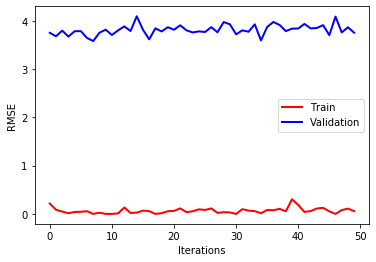

In [20]:
num_iters = 50
J_history = []
J_test_history = []

for i in range(num_iters):
    abr = AdaBoostRegressor(tree_cv, n_estimators=50, learning_rate=1 / (1 + i))
    model: AdaBoostRegressor = abr.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    abr_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    
    y_pred_test = model.predict(X_test)
    abr_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    J_history.append(abr_rmse_train)
    J_test_history.append(abr_rmse_test)
    
plt.plot(range(num_iters), J_history, '-r', LineWidth=2)
plt.plot(range(num_iters), J_test_history, '-b', LineWidth=2)
plt.ylabel('RMSE')
plt.xlabel('Iterations')
plt.legend(['Train', 'Test'])
 

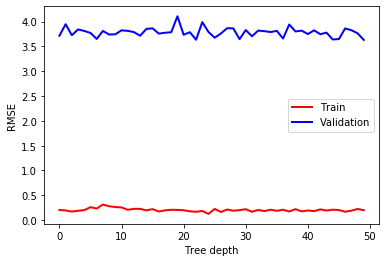

In [23]:
num_iters = 50
J_history = []
J_test_history = []

for i in range(num_iters):
    tree_cv = GridSearchCV(tree, {"max_depth": [1 + i, None], "random_state": [42, None]})
    abr = AdaBoostRegressor(tree_cv, n_estimators=50)
    model: AdaBoostRegressor = abr.fit(X_train, y_train)
    
    y_pred_train = model.predict(X_train)
    abr_rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
    
    y_pred_test = model.predict(X_test)
    abr_rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
    
    J_history.append(abr_rmse_train)
    J_test_history.append(abr_rmse_test)
    
plt.plot(range(num_iters), J_history, '-r', LineWidth=2)
plt.plot(range(num_iters), J_test_history, '-b', LineWidth=2)
plt.ylabel('RMSE')
plt.xlabel('Tree depth')
plt.legend(['Train', 'Validation'])

Можно заметить, что при изменении параметров 'число итераций' и 'глубина дерева' алгоритм не переобучается. 
Более того, ошибка, при изменении параметров, практически не меняется.

#### 9. Сравните качество, получаемое с помощью градиентного бустинга с качеством работы линейной регрессии. Для этого обучите LinearRegression из sklearn.linear_model (с параметрами по умолчанию) на обучающей выборке и оцените для прогнозов полученного алгоритма на тестовой выборке RMSE.

In [30]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred_1 = reg.predict(X_test)
r2 = reg.score(X_test, y_test)
OLS_rmse = np.sqrt(mean_squared_error(y_test, y_pred_1))
print(f'GB score = {abr_r2}, LR score = {r2}')
print(f'GB RMSE = {abr_rmse}, LR RMSE = {OLS_rmse}')

GB score = 0.8438016903430736, LR score = 0.7450343040728142
GB RMSE = 4.037023539083976, LR RMSE = 5.157794006761


Градиентый бустинг показал лучший результат.
RMSE градиентный бустинг = 0.84
RMSE линейная регрессия = 0.74